In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt
import datetime

In [2]:
torch.manual_seed(1)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
train_dataset = datasets.ImageFolder(root='rps', transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


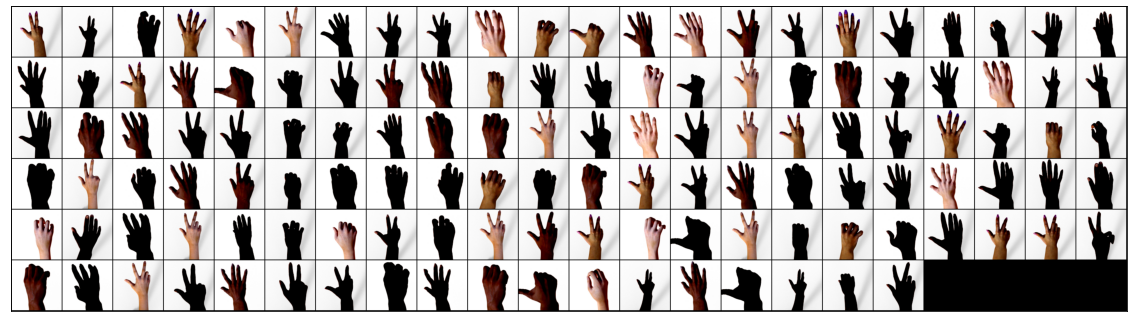

In [9]:
show_batch(train_loader)

In [10]:
image_shape = (3, 128, 128)
image_dim = int(np.prod(image_shape))
latent_dim = 100

In [11]:
n_classes = 3
embedding_dim = 100

In [12]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))
        
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
           

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image




In [14]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_si

In [15]:
a = torch.ones(100)
b = torch.ones(1)
b = b.long()
a = a.to(device)
b = b.to(device)

In [16]:
# generator((a,b))

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*128*128))
             
        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

In [18]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=49152, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)


In [19]:
a = torch.ones(2,3,128,128)
b = torch.ones(2,1)
b = b.long()
a = a.to(device)
b = b.to(device)

In [20]:
c = discriminator((a,b))
c.size()

torch.Size([2, 1])

In [21]:
adversarial_loss = nn.BCELoss() 

In [22]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss

In [23]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [24]:
learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [27]:
num_epochs = 2
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()

      
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
      
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
        
       
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        #D_fake_loss.backward()
      
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_image(generated_image.data[:50], 'torch/images/sample_%d'%epoch + '.png', nrow=5, normalize=True)
     
    torch.save(generator.state_dict(), 'torch/training_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), 'torch/training_weights/discriminator_epoch_%d.pth' % (epoch))

Epoch: [1/2]: D_loss: 0.350, G_loss: 2.001
Epoch: [2/2]: D_loss: 0.339, G_loss: 1.888


In [28]:
# generate_images(generator, noise_vector)

NameError: name 'generate_images' is not defined

In [29]:
generator.load_state_dict(torch.load('torch/training_weights/generator_epoch_1.pth'), strict=False)
generator.eval()

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_si

In [30]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
from matplotlib import gridspec

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)


pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])

interpolated = torch.tensor(interpolated)
interpolated = interpolated.to(device)
interpolated = interpolated.type(torch.float32)

output = None
for label in range(3):
    labels = torch.ones(10) * label
    labels = labels.to(device)
    labels = labels.unsqueeze(1).long()
    print(labels.size())
    predictions = generator((interpolated, labels))
    predictions = predictions.permute(0,2,3,1)
    pred = predictions.detach().cpu()
    if output is None:
        output = pred
    else:
        output = np.concatenate((output,pred))

torch.Size([10, 1])
torch.Size([10, 1])
torch.Size([10, 1])


In [31]:
output.shape

(30, 128, 128, 3)

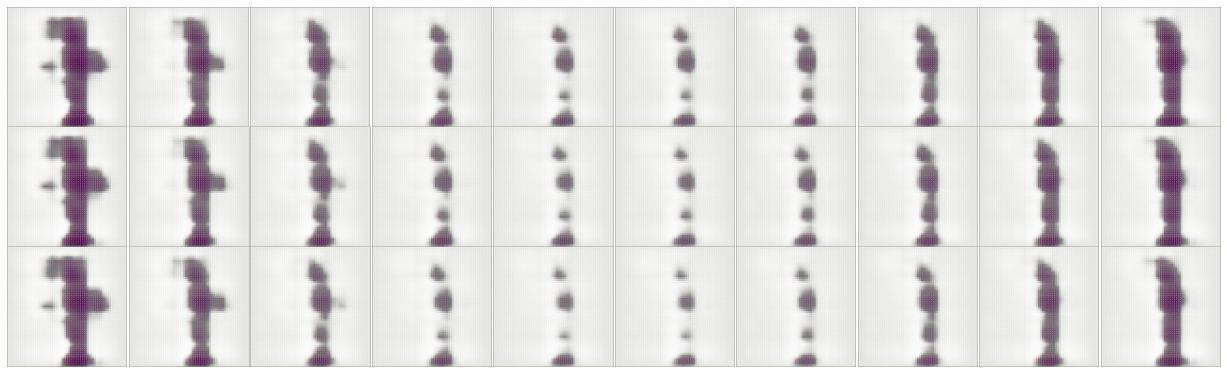

In [33]:
nrow = 3
ncol = 10
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1,1, 1,1, 1, 1, 1, 1],
     wspace=0.0, hspace=0.0, top=0.2, bottom=0.00, left=0.17, right=0.845) 

#output = output.reshape(-1, 128, 128, 3)
#print("Generated Images are Conditioned on Label:", label_dict[np.array(labels)[0]])
k = 0
for i in range(nrow):
    for j in range(ncol):
        pred = (output[k, :, :, :] + 1 ) * 127.5
        pred = np.array(pred)  
        ax= plt.subplot(gs[i,j])
        ax.imshow(pred.astype(np.uint8))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.axis('off')
        k += 1   


#plt.savefig('result_torch.png',  dpi=300)
plt.show()